In [1]:
import pandas as pd
import json
import numpy as np


from imagedata_NeoroScan import medical_train, medical_test, display_img
from image_loading import * 
print("All Prerequisites Loaded Successfully")

Found 3157
Successfully loaded 3157
Found 3453
Successfully loaded 3453
Found 711
Successfully loaded 711
Found 1424
Successfully loaded 1424
Total Training Images: 8745
All Training Images Loaded Successfully!
Found 136
Successfully loaded 136
Found 140
Successfully loaded 140
Found 100
Successfully loaded 100
Found 136
Successfully loaded 136
Total Training Images: 8745
All Training Images Loaded Successfully!
Total Testing Images: 512
All Testing Images loaded successfully!
2.9.1+cpu
2.2.4
11.1.0
 13           RESUME                   0

 14           LOAD_GLOBAL              0 (img)
              LOAD_ATTR                2 (open)
              PUSH_NULL
              LOAD_FAST                0 (image_path)
              CALL                     1
              STORE_FAST               1 (image)

 15           LOAD_GLOBAL              4 (torch)
              LOAD_ATTR                6 (from_numpy)
              PUSH_NULL
              LOAD_GLOBAL              8 (np)
              LO

In [2]:
print("Medical Training Sets =",len(medical_train))
print("Medical Testing Sets =",len(medical_test))

Medical Training Sets = 4
Medical Testing Sets = 4


In [3]:
print("Structure of Training Images :")
str_training = structure_img(medical_train)

Structure of Training Images :
Type: <class 'list'>
Lenght: 4
  Type: <class 'list'>
  Lenght: 3157
    Type: <class 'PIL.Image.Image'>


In [4]:
print("Structure of Testing Images :")
str_testing = structure_img(medical_test)

Structure of Testing Images :
Type: <class 'list'>
Lenght: 4
  Type: <class 'list'>
  Lenght: 136
    Type: <class 'PIL.Image.Image'>


Training Images...


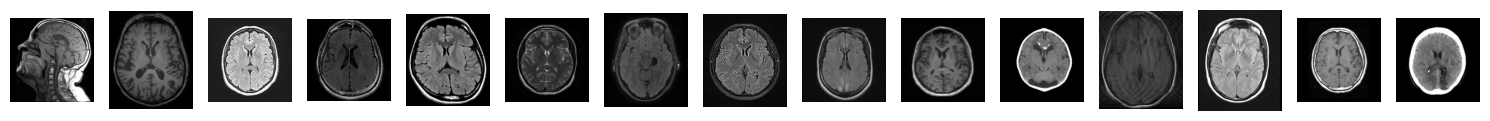

In [5]:
print("Training Images...")
train_image = display_img(medical_train, 0, 15)

Testing Images...


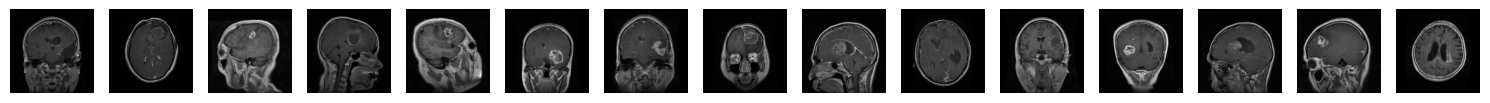

In [6]:
print("Testing Images...")
test_image = display_img(medical_test, 0, 15)


In [7]:
import torch, torchvision.transforms as T
from torchvision import models

model = models.resnet50(pretrained = True)
model = torch.nn.Sequential(*list(model.children()))[:-1]

C:\Users\Tanmay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Tanmay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
for img_var in medical_train:
    print("vectorising train set...")
    print("="*20)
    vector_train = []

    for img in img_var[:200]:
        
       
        prep = prep = T.Compose([T.Resize((256,256)), T.CenterCrop((224,224)),T.Grayscale(num_output_channels= 3), T.ToTensor()])
        tensor = prep(img).unsqueeze(0)

        vector_tr = model(tensor)

vectorising train set...
vectorising train set...
vectorising train set...
vectorising train set...


In [9]:
for img_var in medical_test:
    print("vectorising test set...")
    print("="*20)
    vector_test = []

    for img in img_var[:200]:
        prep = T.Compose([T.Resize((256,256)), T.CenterCrop((224,224)),T.Grayscale(num_output_channels= 3), T.ToTensor()])
        tensor = prep(img).unsqueeze(0)

        vector_ts = model(tensor)

vectorising test set...
vectorising test set...
vectorising test set...
vectorising test set...


In [10]:
print("Vectorized Training Set:", vector_tr, sep ="\n")
print(type(vector_tr))

x_tr = vector_tr.view(vector_tr.size(0), -1)
x_ts = vector_ts.view(vector_ts.size(0), -1)

Vectorized Training Set:
tensor([[[[0.3265]],

         [[0.5237]],

         [[0.4463]],

         ...,

         [[0.3179]],

         [[0.4874]],

         [[0.3135]]]], grad_fn=<MeanBackward1>)
<class 'torch.Tensor'>


In [11]:
y_tr = np.zeros(x_tr.shape[0], dtype= int)
y_ts = np.zeros(x_ts.shape[0], dtype= int)

In [12]:
import pandas as pd
import numpy as np
import torch

def to_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return x 

x_tr = to_numpy(x_tr)
x_ts = to_numpy(x_ts)
y_tr = to_numpy(y_tr)
y_ts = to_numpy(y_ts)

feature_cols = [f"feat_{i}" for i in range(x_tr.shape[1])]
print(f"Feature Columns: {len(feature_cols)}")

df_1 = pd.DataFrame(x_tr, columns = feature_cols)
df_1["labels"] = y_tr
df_1["split"] = "train"

df_2 = pd.DataFrame(x_ts, columns = feature_cols)
df_2["labels"] = y_ts
df_2["split"] = "test"

df = pd.concat([df_1, df_2], ignore_index= True)
print(df.head())
print(df["split"].value_counts())








Feature Columns: 2048
     feat_0    feat_1    feat_2    feat_3    feat_4    feat_5    feat_6  \
0  0.326502  0.523656  0.446253  0.398547  0.537282  0.526137  0.491680   
1  0.391730  0.526088  0.526207  0.370039  0.574461  0.557378  0.492022   

     feat_7    feat_8    feat_9  ...  feat_2040  feat_2041  feat_2042  \
0  0.493327  0.441357  0.436572  ...   0.442514   0.377806   0.420250   
1  0.460746  0.440959  0.401171  ...   0.430256   0.426530   0.447638   

   feat_2043  feat_2044  feat_2045  feat_2046  feat_2047  labels  split  
0   0.188733   0.403240   0.317930   0.487429   0.313506       0  train  
1   0.183841   0.490627   0.364798   0.476493   0.364989       0   test  

[2 rows x 2050 columns]
split
train    1
test     1
Name: count, dtype: int64


In [13]:
print("Vectorized Testing Set:", vector_ts, sep="\n")
print(type(vector_ts))


Vectorized Testing Set:
tensor([[[[0.3917]],

         [[0.5261]],

         [[0.5262]],

         ...,

         [[0.3648]],

         [[0.4765]],

         [[0.3650]]]], grad_fn=<MeanBackward1>)
<class 'torch.Tensor'>


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

x_train = df[df.split == "train"].drop(columns=["labels","split"]).values
y_train = df[df.split == "train"]["labels"].values

x_test = df[df.split == "test"].drop(columns=["labels" , "split"]).values
y_test = df[df.split == "test"]["labels"].values

rf = RandomForestClassifier(
    n_estimators= 100,
    random_state=28,
    verbose= 10,
    warm_start= True,
    criterion= "gini"


)

rf.fit(x_train, y_train)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.1s


building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.1s


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
# x_train

In [16]:
# df.loc[df.sample(frac=0.2 , random_state = 42).index, "split"] = "test"

# x_test = df[df.split == "test"].drop(columns = ["labels", "split"]).values
# y_test = df[df.split == "test"]["labels"].values

In [35]:
x_test

array([[0.39173007, 0.52608824, 0.52620727, ..., 0.3647975 , 0.47649312,
        0.36498925]], shape=(1, 2048), dtype=float32)

In [36]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

y_pred = rf.predict(x_test)
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_pred, y_test))
print("Recall:", recall_score(y_pred, y_test))
print("F1:", f1_score(y_pred, y_test))

Accuracy: 1.0
Precision: 0.0
Recall: 0.0
F1: 0.0


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  60 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  84 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  97 tasks      | elapsed:    0.0s
C:\Users\Tanmay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Pr

In [37]:
from sklearn.model_selection import train_test_split

x = np.vstack([x_tr, x_ts])
y = np.hstack([y_tr, y_ts])

print(x)
print(y)





[[0.32650167 0.52365565 0.44625306 ... 0.31793007 0.48742867 0.31350648]
 [0.39173007 0.52608824 0.52620727 ... 0.3647975  0.47649312 0.36498925]]
[0 1]


In [19]:
from sklearn.cluster import KMeans as km

kmeans = km(
    n_clusters= 1,
    random_state= 42,
    max_iter= 300

    
)

print("Model Type Info :: ", type(kmeans))
print("Model Description ::", kmeans)

Model Type Info ::  <class 'sklearn.cluster._kmeans.KMeans'>
Model Description :: KMeans(n_clusters=1, random_state=42)


In [20]:
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [21]:
print("Vectorised Data's Type", sep="/n")
print(type(vector_tr), type(vector_ts))
print("Vectorised Data's Shape", sep="/n")
print("Training Value =",vector_tr.shape,"Testing Value =", vector_ts.shape )
print("Vectorised Data's Unsqueezed Shape ", sep="/n")
print("Training UnSqueezed =", vector_tr.unsqueeze(0).shape, "Testing Unsqueezed =", vector_ts.unsqueeze(0).shape)


Vectorised Data's Type
<class 'torch.Tensor'> <class 'torch.Tensor'>
Vectorised Data's Shape
Training Value = torch.Size([1, 2048, 1, 1]) Testing Value = torch.Size([1, 2048, 1, 1])
Vectorised Data's Unsqueezed Shape 
Training UnSqueezed = torch.Size([1, 1, 2048, 1, 1]) Testing Unsqueezed = torch.Size([1, 1, 2048, 1, 1])


In [22]:
print("Structure of Vector Train :")
str_training_v = structure_img(vector_tr)

print("Structure of Vector Testing :")
str_testing_v = structure_img(vector_ts)

Structure of Vector Train :
Type: <class 'torch.Tensor'>
Structure of Vector Testing :
Type: <class 'torch.Tensor'>


In [23]:
x_tr = (vector_tr.view(vector_tr.size(0), -1)).detach().cpu().numpy()
x_ts = (vector_ts.view(vector_ts.size(0), -1)).detach().cpu().numpy()

y_tr = torch.tensor([0] * x_tr.shape[0]).detach().cpu().numpy()
y_ts = torch.tensor([1] * x_tr.shape[0]).detach().cpu().numpy()

training_material = x_tr , x_ts, y_tr, y_ts
print(training_material)

(array([[0.32650167, 0.52365565, 0.44625306, ..., 0.31793007, 0.48742867,
        0.31350648]], shape=(1, 2048), dtype=float32), array([[0.39173007, 0.52608824, 0.52620727, ..., 0.3647975 , 0.47649312,
        0.36498925]], shape=(1, 2048), dtype=float32), array([0]), array([1]))


In [24]:
y_tr = torch.as_tensor(y_tr)
y_ts = torch.as_tensor(y_ts)

y = torch.cat([y_tr,y_ts],dim = 0)
y = y.detach().cpu().numpy()



In [25]:
print("X_train:", x_tr)
print("x_test:",x_ts)
print("y_train:",y_tr)
print("y_test:",y_ts)

X_train: [[0.32650167 0.52365565 0.44625306 ... 0.31793007 0.48742867 0.31350648]]
x_test: [[0.39173007 0.52608824 0.52620727 ... 0.3647975  0.47649312 0.36498925]]
y_train: tensor([0])
y_test: tensor([1])


In [26]:
kmeans_x_cluster = vector_tr.view(vector_tr.size(0), -1)
kmeans_x_cluster


tensor([[0.3265, 0.5237, 0.4463,  ..., 0.3179, 0.4874, 0.3135]],
       grad_fn=<ViewBackward0>)

In [27]:
print("="*20)
print("Model Training ...")
print("="*20)
cluster = kmeans.fit_predict(kmeans_x_cluster.detach().cpu().numpy())
print(cluster)

Model Training ...
[0]


In [28]:
# y_pred = rfc.predict(x_ts)
# print("Y_prediction :", y_pred)


In [29]:
# from sklearn.metrics import accuracy_score, precision_score , f1_score, recall_score

# accuracy = accuracy_score(y_pred, y_ts)
# precision = precision_score(y_pred, y_ts)
# f_1 = f1_score(y_pred, y_ts)
# recall = recall_score(y_pred, y_ts)


